# Node classification practice

In [1]:
#Libraries we are going to use
# Install required packages.
import os
import torch #Library for deep learning
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
COLLAB_ENV = True
if COLLAB_ENV:
    !pip install 'scipy>=1.8'
    !pip install mycolorpy
import numpy as np #Library for linear algebra
import matplotlib.pyplot as plt #Library for plotting
import networkx as nx #Library for graph
from torch_geometric.datasets import Planetoid,WebKB, Actor #Library for graph dataset and deep learning on graphs
from torch_geometric.utils import to_dense_adj
import warnings
warnings.filterwarnings("ignore") # Get rid of warnings

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=77ee86f0904a2c0f0174d702bfa0605f4609e5f320a78e95c1a8af105725edea
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


### 1. Load data and visualize it

In [2]:
'''
    Load the dataset:
        * root: The root directory where the dataset should be saved.
        * name: The name of the dataset (cora, citeseer or pubmed).
        * transform: A function/transform that takes in an Data object of the dataset and returns a transformed version. The data object will be transformed before every access.
    Returns:
        * Dataset object
'''

data_Texas = WebKB(root='/tmp/Texas', name='Texas') # Load the Wisconsin dataset (homogeneous)
dataset = data_Texas
data = dataset[0] # Get the first graph object (in this case is only one graph, while in Graph classification there are multiple graphs)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()
print(data) # Note that the adjacency matrix is not stored explicitly but in the edge_index attribute.
            # The edge_index attribute is a 2 x E tensor, with each column denoting an edge.
            # The first row denotes the source nodes and the second row the destination nodes of the edges.
            # The nodes are numbered consecutively starting from zero.
            # The features are stored in the x attribute, which is a N x F tensor, with N being the number of nodes and F the number of features per node.
            # The labels are stored in the y attribute, which is a vector of length N, with each entry denoting the class of the corresponding node.
print('===========================================================================================================')
adj = to_dense_adj(data.edge_index)[0] # Convert the sparse adjacency matrix to a dense adjacency matrix
print("Shape of the new adjacency matrix: ",adj.shape)
#Let's get statistics about the graph adjacency matrix
print("Number of nodes: ",adj.shape[0])
print("Number of edges: ",round(adj.sum().item()))
print("Density: ",round((adj.sum()/(adj.shape[0]*adj.shape[0])).item(),4))
print("Maximum node degree: ",round(adj.sum(axis=1).max().item()))
print("Minimum node degree: ",round(adj.sum(axis=1).min().item()))
print("Average node degree: ",round(adj.sum(axis=1).mean().item()))
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print('===========================================================================================================')


Processing...



Dataset: texas():
Number of graphs: 1
Number of features: 1703
Number of classes: 5

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
Shape of the new adjacency matrix:  torch.Size([183, 183])
Number of nodes:  183
Number of edges:  325
Density:  0.0097
Maximum node degree:  104
Minimum node degree:  0
Average node degree:  2
Has isolated nodes: False
Has self-loops: True
Is undirected: False


Done!


In [ ]:
def calculate_homophily(edge_index, labels):
    num_edges = edge_index.size(1)
    same_label_edges = 0

    for i in range(num_edges):
        src, dst = edge_index[:, i]
        if labels[src] == labels[dst]:
            same_label_edges += 1

    homophily = same_label_edges / num_edges
    return homophily

homophily = calculate_homophily(data.edge_index, data.y)
print(f'Grado de homofilia: {homophily:.4f}')

Grado de homofilia: 0.1077


### 1.1 Visualize the graph

Data(x=[183, 1703], edge_index=[2, 574], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10], num_nodes=183, num_edges=295)


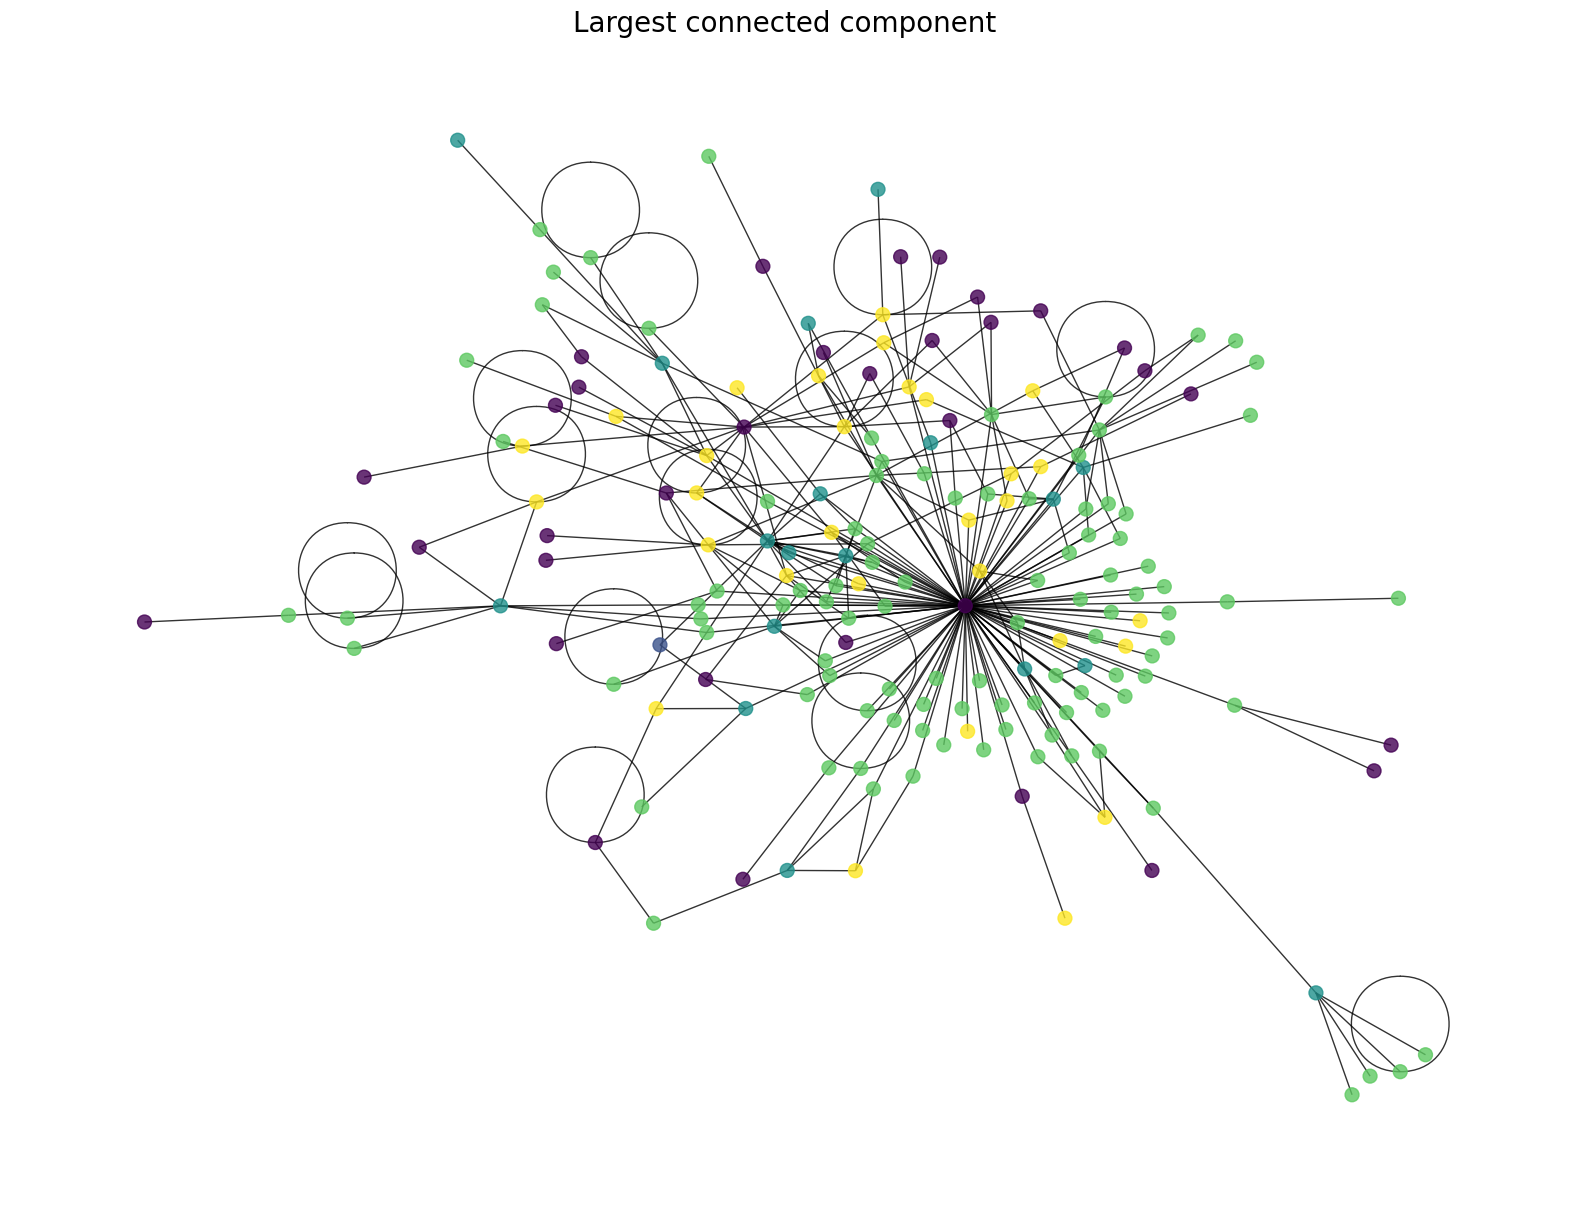

In [ ]:
# To visualize the graph we are going to use networkx library, but first we need to convert the graph to networkx format
from torch_geometric.utils import to_networkx
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
# Now we are going to get the largest connected component of the graph, because the graph is not connected!
Gcc = sorted(nx.connected_components(A), key=len, reverse=True) # Get the sorted list of connected components
A = A.subgraph(Gcc[0]) # Get the largest connected component
G = nx.adjacency_matrix(A)
# All the following code is just for plotting the graph, so you can ignore it
# This how we can get the edge_index attribute for the largest connected component
g_tensor = torch.tensor(G.todense())
new_edge_index = g_tensor.nonzero().t().contiguous()
# This is how we create the new data object for the largest connected component
data.x = data.x[list(A.nodes())]
data.y = data.y[list(A.nodes())]
data.edge_index = new_edge_index
data.num_nodes = len(A.nodes())
data.num_edges = len(A.edges())
print(data)
# Now we can plot the graph
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
plt.figure(figsize=(20,15))
plt.title('Largest connected component',fontsize=20)
pos = nx.spring_layout(A,seed=12)
#Let's drow the graph, adding borders to the nodes
'''
    Arguments of nx.draw:
        * G: The graph to draw.
        * node_color: The color of the nodes.
        * pos: A dictionary with nodes as keys and positions as values.
        * cmap: A colormap or registered colormap name.
        * node_size: The size of the nodes.
        * edge_color: The color of the edges.
        * width: The width of the edges.
        * with_labels: Whether to draw the node labels.
        * node_shape: The shape of the nodes.
        * alpha: The node transparency.
    Returns:
        * None
'''
nx.draw(A,node_color=data.y,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()

### 1.3 Visualize full graph [Optional]

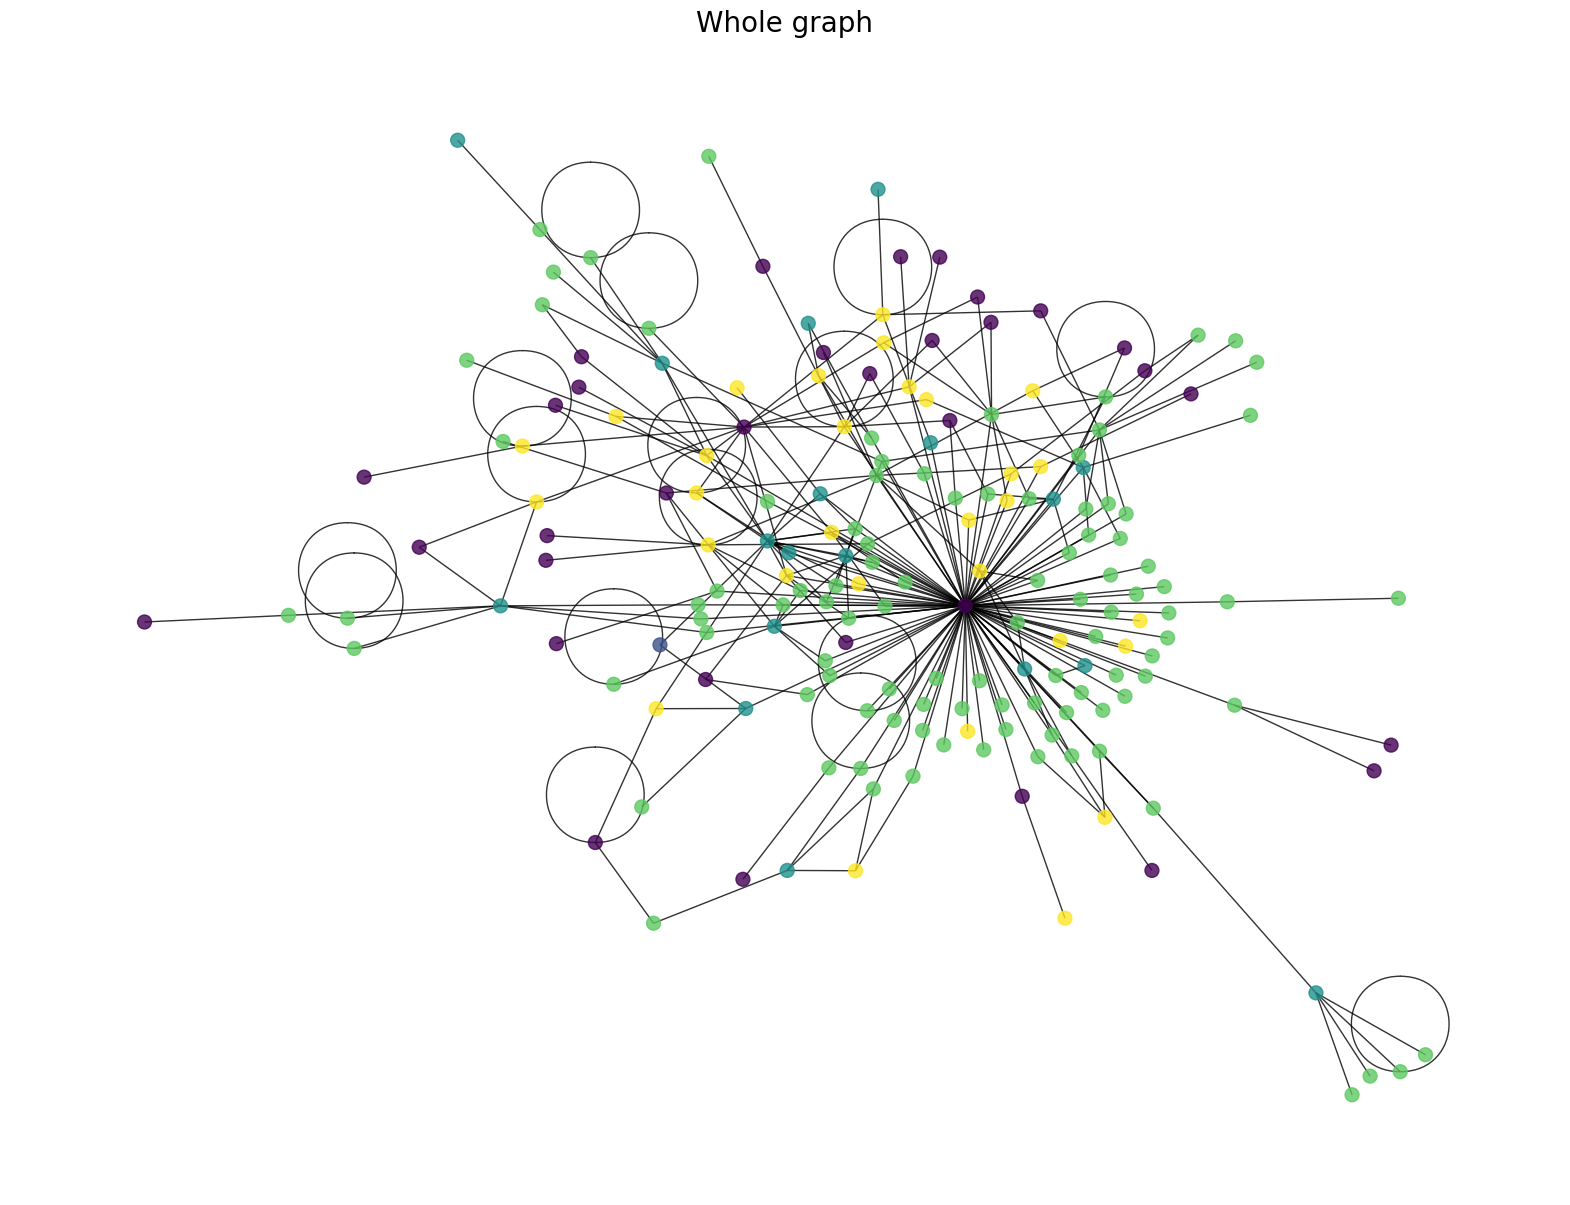

In [ ]:
# The same as above but with the whole graph
data = dataset[0]
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(20,15))
plt.title('Whole graph',fontsize=20)
color = data.y
pos = nx.spring_layout(G,seed=12)
nx.draw(G,node_color=color,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()


### 2. Train a GCN model

#### Utility functions

In [3]:
'''
    Arguments of train:
        * model: The model to train.
        * data: The data object.
        * optimizer: The optimizer to use.
        * train_mask: The mask of the training nodes.
        * criterion: The loss function to use.
    Returns:
        * loss: The loss of the model.
        * acc: The accuracy of the model.
'''
def train(model, data, optimizer,train_mask,device,criterion = torch.nn.CrossEntropyLoss()):
    model.train()
    optimizer.zero_grad() # Clear gradients.
    #Make sure that we only use the features of the training nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[train_mask] = data.x[train_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    # al modelo se le pasan las características y las conexiones
    out = model(features, data.edge_index) # Perform a single forward pass.
    # Lo que me equivoco, solo en entrenamiento
    loss = criterion(out[train_mask], data.y[train_mask]) # Compute the loss solely based on the training nodes.
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[train_mask].eq(data.y[train_mask]).sum().item() / train_mask.sum().item() # Derive ratio of correct predictions.
    # Actualizar la loss, cambiar las matrices W de cada neurona
    loss.backward() # Derive gradients.
    optimizer.step() # Update parameters based on gradients.
    return loss,acc
'''
    Arguments of validation:
        * model: The model to train.
        * data: The data object.
        * val_mask: The mask of the validation nodes.
    Returns:
        * acc: The accuracy of the model.
'''
@torch.no_grad()
def validation(model,data,val_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the validation nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[val_mask] = data.x[val_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[val_mask].eq(data.y[val_mask]).sum().item() / val_mask.sum().item() # Derive ratio of correct predictions.
    return acc
'''
    Arguments of test:
        * model: The model to train.
        * data: The data object.
        * test_mask: The mask of the test nodes.
    Returns:
        * acc: The accuracy of the model.
'''
@torch.no_grad()
def test(model,data,test_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the testing nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[test_mask] = data.x[test_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[test_mask].eq(data.y[test_mask]).sum().item() / test_mask.sum().item() # Derive ratio of correct predictions.
    return acc

#### Split dataset

In this section we will split the dataset into training, validation and test sets. We will use the training set to train the model, the validation set to tune the hyperparameters and the test set to evaluate the model. We will use two functions for the splits. One function will give as a semi-supervised split where we will have a small number of labeled nodes in the training set and the rest of the nodes will be unlabeled. The other function will give us a fully supervised split where all the nodes in the training set will be labeled.

In [4]:
from sklearn.model_selection import train_test_split
'''
    Arguments of get_semi_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 48%/32%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_semi_supervised_split(data,seed):
    #We are going to use 48% of the nodes for training, 32% for testing and 20% for validation
    #First we split the nodes in 80% for training and 20% for testing
    #Then we split the training nodes in 48% for training and 32% for validation over the 80% of the nodes
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.20,random_state=seed, shuffle=True)
    train_split, val_split = train_test_split(train_split, test_size=0.40,random_state=seed, shuffle=True)

    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True

    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True

    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True

    return train_mask,test_mask,val_mask
'''
    Arguments of get_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 60%/20%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_supervised_split(data,seed):
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.40,random_state=seed, shuffle=True)
    test_split, val_split = train_test_split(test_split, test_size=0.50,random_state=seed, shuffle=True)

    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True

    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True

    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True

    return train_mask, test_mask, val_mask

#### Create the model

In this section we will create our model for node classification. We will use a GCN model with 2 hidden layers. The input to the model will be the node features and the output will be the logits for each node in the graph. We will use the cross entropy loss function and the Adam optimizer.

##### GCN

In [5]:
from torch_geometric.nn import GCNConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class GCN(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    # hidden channels: capa intermedia
    def __init__(self,hidden_channels = 16):
        super(GCN, self).__init__()
        # 2-layer GCN
        # GCConv(tamaño entrada, tamaño salida)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # 16 hidden units
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    # lo que aplica el modelo
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(GCN())

GCN(
  (conv1): GCNConv(1703, 16)
  (conv2): GCNConv(16, 5)
)


##### SAGE

In [6]:
from torch_geometric.nn import SAGEConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class SAGE(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    # hidden channels: capa intermedia
    def __init__(self,hidden_channels = 16):
        super(SAGE, self).__init__()
        # 2-layer GCN
        # GCConv(tamaño entrada, tamaño salida)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels, aggr='max') # 16 hidden units
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    # lo que aplica el modelo
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(SAGE())

SAGE(
  (conv1): SAGEConv(1703, 16, aggr=max)
  (conv2): SAGEConv(16, 5, aggr=mean)
)


##### Cheb

In [7]:
from torch_geometric.nn import ChebConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class Cheb(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    # hidden channels: capa intermedia
    def __init__(self,hidden_channels = 16):
        super(Cheb, self).__init__()
        # 2-layer GCN
        # GCConv(tamaño entrada, tamaño salida)
        self.conv1 = ChebConv(dataset.num_features, hidden_channels, K=10, normalization='sym') # 16 hidden units
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes, K=10, normalization='sym') # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    # lo que aplica el modelo
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(Cheb())

Cheb(
  (conv1): ChebConv(1703, 16, K=10, normalization=sym)
  (conv2): ChebConv(16, 5, K=10, normalization=sym)
)


##### GAT

In [8]:
from torch_geometric.nn import GATConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class GAT(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    # hidden channels: capa intermedia
    def __init__(self,hidden_channels = 16):
        super(GAT, self).__init__()
        # 2-layer GCN
        # GCConv(tamaño entrada, tamaño salida)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=1) # 16 hidden units
        self.conv2 = GATConv(hidden_channels, dataset.num_classes, heads=1) # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    # lo que aplica el modelo
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(GAT())

GAT(
  (conv1): GATConv(1703, 16, heads=1)
  (conv2): GATConv(16, 5, heads=1)
)


##### MLP

In [9]:
from torch.nn import Linear
# Same as GCN but with Linear layers instead of GCNConv layers. If we use MLP as a model, we can't take into account the graph STRUCTURE.
class MLP(torch.nn.Module):
    def __init__(self,hidden_channels = 16):
        super(MLP, self).__init__()
        # 2-layer GCN
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # edge_index is not used
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x.softmax(dim=1)
print(MLP())

MLP(
  (lin1): Linear(in_features=1703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=5, bias=True)
)


Using the above models as templates, **create as many cells as models**.

#### Train the models

In [10]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train and test (include your own models)
models = [GCN(), MLP(), SAGE(), Cheb(), GAT()]
global_results = []
global_best_models = []
for j in range(len(models)):
    ExperimentResult = []
    best_model = None
    print(data)
    for i in range(10):
        print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model is None or acc > best_model[1]:
            best_model = [model, acc]
        ExperimentResult.append(acc)
        del model
    print(models[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult)*100, np.std(ExperimentResult)*100))
    global_results.append(ExperimentResult.copy())
    global_best_models.append(best_model.copy())

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch: 012, Loss: 1.19744, Train Acc: 0.70115, Val Acc: 0.62712
Epoch: 013, Loss: 1.18365, Train Acc: 0.73563, Val Acc: 0.64407
Epoch: 014, Loss: 1.20747, Train Acc: 0.73563, Val Acc: 0.64407
Epoch: 015, Loss: 1.18559, Train Acc: 0.74713, Val Acc: 0.64407
Epoch: 016, Loss: 1.25516, Train Acc: 0.66667, Val Acc: 0.64407
Epoch: 017, Loss: 1.15982, Train Acc: 0.74713, Val Acc: 0.64407
Epoch: 018, Loss: 1.19138, Train Acc: 0.71264, Val Acc: 0.64407
Epoch: 019, Loss: 1.18271, Train Acc: 0.74713, Val Acc: 0.64407
Epoch: 020, Loss: 1.16304, Train Acc: 0.74713, Val Acc: 0.64407
Epoch: 021, Loss: 1.19126, Train Acc: 0.71264, Val Acc: 0.62712
Epoch: 022, Loss: 1.11852, Train Acc: 0.80460, Val Acc: 0.59322
Epoch: 023, Loss: 1.13527, Train Acc: 0.78161, Val Acc: 0.59322
Epoch: 024, Loss: 1.17711, Train Acc: 0.73563, Val Acc: 0.59322
Epoch: 025, Loss: 1.11619, Train Acc: 0.81609, Val Acc: 0.59322
Epoch: 026, Loss: 1.12867, Train Acc: 0.781

#### Visualize the results and the embedding

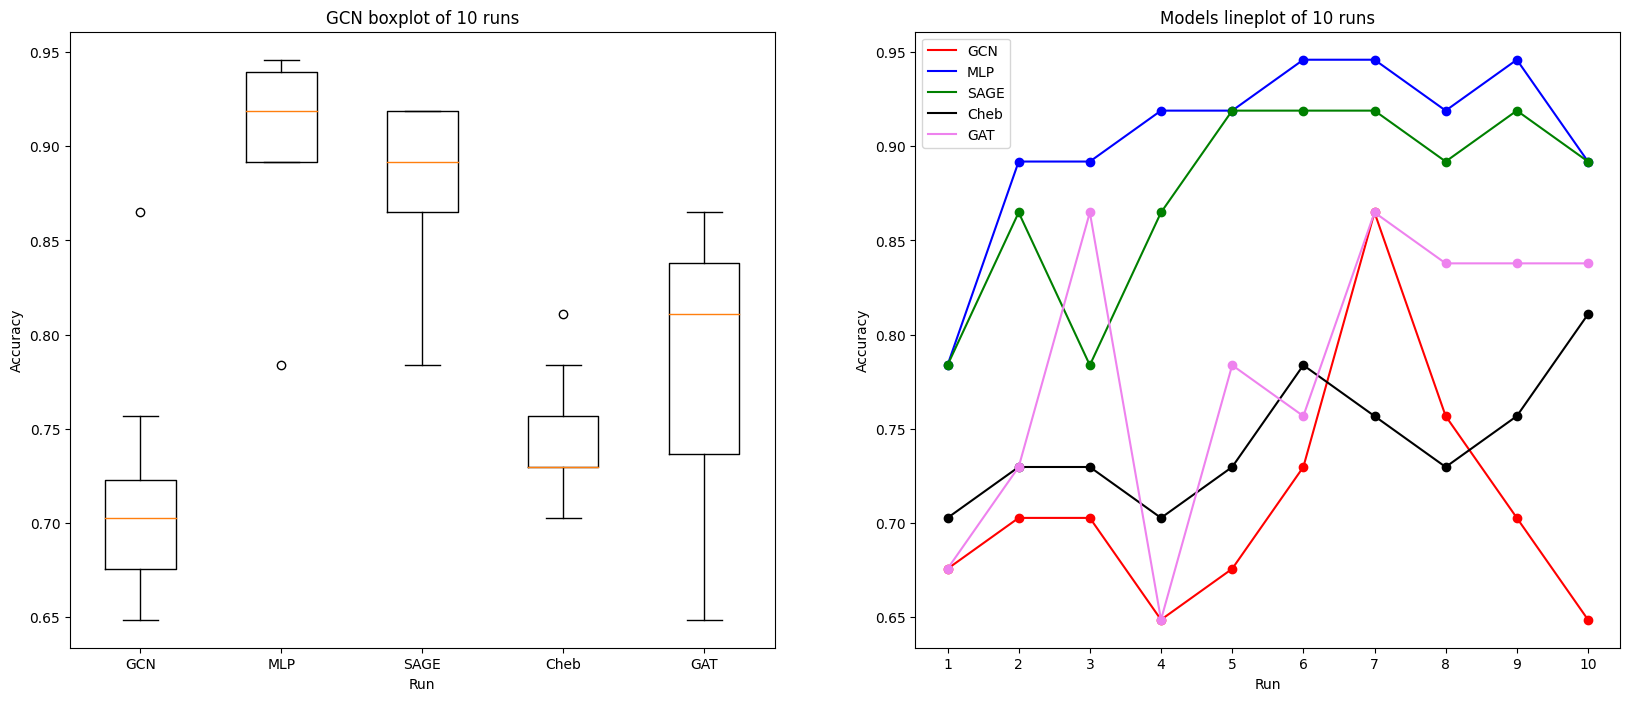

In [11]:
fig,axs = plt.subplots(1,2,figsize=(20,8))
axs[0].set_title('GCN boxplot of 10 runs')
axs[0].boxplot(global_results,labels=['GCN','MLP', 'SAGE', 'Cheb', 'GAT'])
axs[0].set_xlabel('Run')
axs[0].set_ylabel('Accuracy')

axs[1].set_title('Models lineplot of 10 runs')
axs[1].plot(range(1,11),global_results[0],'ro',color='red')
axs[1].plot(range(1,11),global_results[0],color='red',label='GCN')

axs[1].plot(range(1,11),global_results[1],'ro',color='blue')
axs[1].plot(range(1,11),global_results[1],color='blue',label='MLP')

axs[1].plot(range(1,11),global_results[2],'ro',color='green')
axs[1].plot(range(1,11),global_results[2],color='green',label='SAGE')

axs[1].plot(range(1,11),global_results[3],'ro',color='k')
axs[1].plot(range(1,11),global_results[3],color='k',label='Cheb')

axs[1].plot(range(1,11),global_results[4],'ro',color='violet')
axs[1].plot(range(1,11),global_results[4],color='violet',label='GAT')

axs[1].set_xticks(range(1,11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.show()

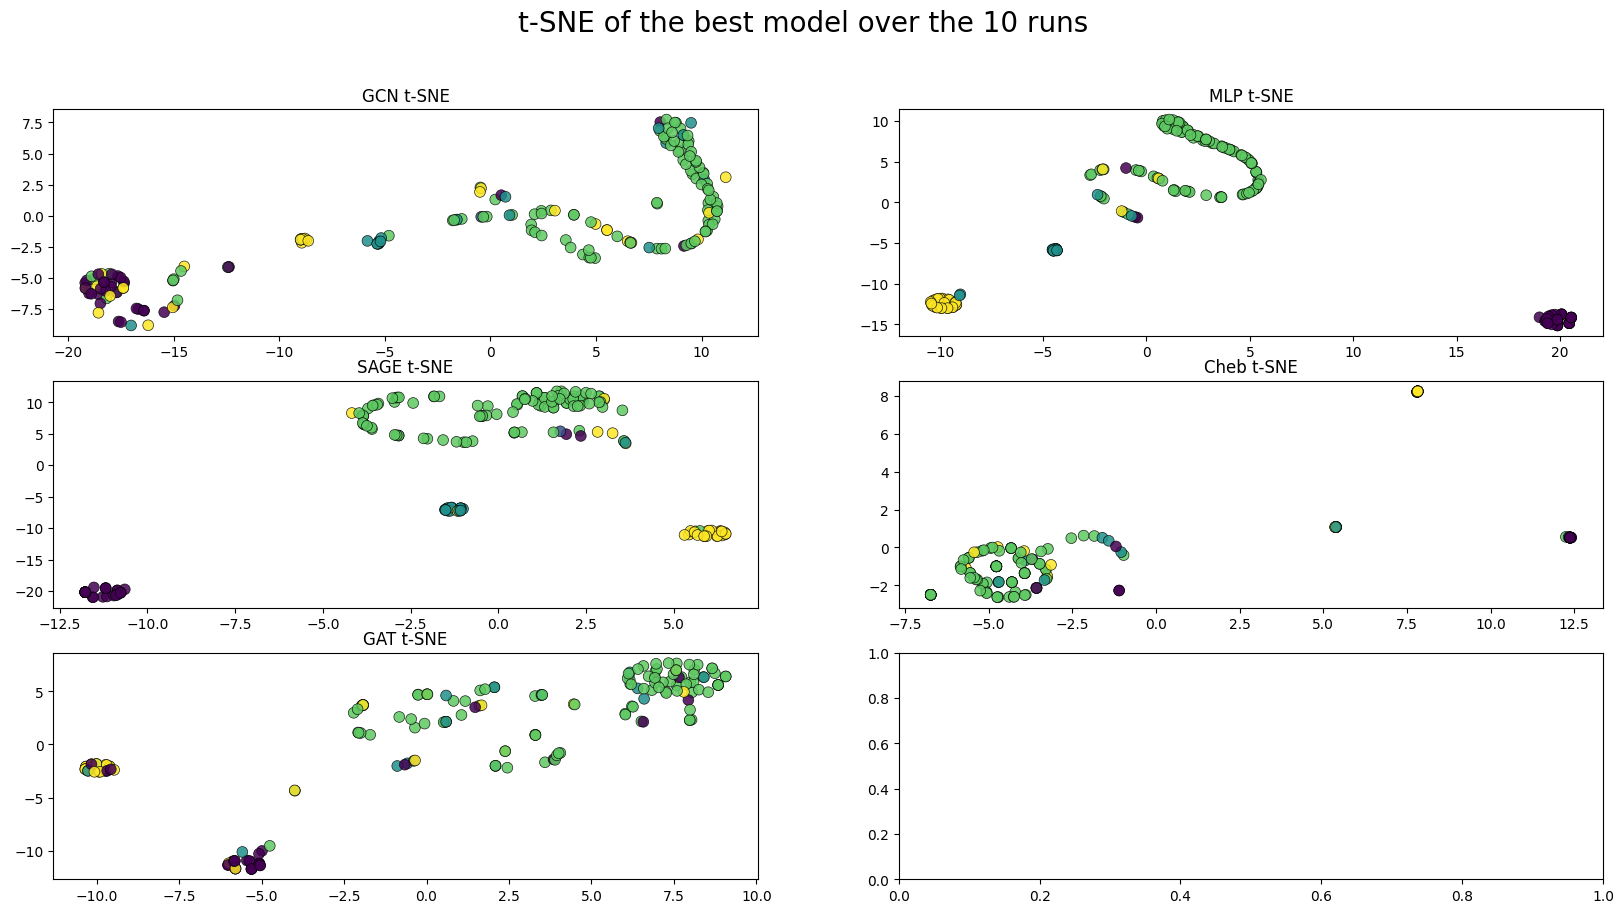

In [12]:
from sklearn.manifold import TSNE
# Let's see the embedding of the best model over the 10 runs

'''
    Arguments of TSNE:
        * n_components: The dimension of the embedded space.
        * random_state: The seed to use for the t-SNE algorithm.
    Returns:
        * tsne_obj: The t-SNE embedding of the nodes.
'''

# GCN
out_gcn = global_best_models[0][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_gcn_results = tsne.fit_transform(out_gcn.detach().cpu().numpy())
# SAGE
out_sage = global_best_models[2][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_sage_results = tsne.fit_transform(out_sage.detach().cpu().numpy())
# Cheb
out_cheb = global_best_models[3][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_cheb_results = tsne.fit_transform(out_cheb.detach().cpu().numpy())
# GAT
out_gat = global_best_models[4][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_gat_results = tsne.fit_transform(out_gat.detach().cpu().numpy())
# MLP
out_mlp = global_best_models[1][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_mlp_results = tsne.fit_transform(out_mlp.detach().cpu().numpy())
# Plot the results
fig,axs = plt.subplots(3,2,figsize=(20,10))
axs[0,0].set_title('GCN t-SNE')
axs[0,0].scatter(tsne_gcn_results[:,0],tsne_gcn_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[0,1].set_title('MLP t-SNE')
axs[0,1].scatter(tsne_mlp_results[:,0],tsne_mlp_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[1,0].set_title('SAGE t-SNE')
axs[1,0].scatter(tsne_sage_results[:,0],tsne_sage_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[1,1].set_title('Cheb t-SNE')
axs[1,1].scatter(tsne_cheb_results[:,0],tsne_cheb_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[2,0].set_title('GAT t-SNE')
axs[2,0].scatter(tsne_gat_results[:,0],tsne_gat_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

fig.suptitle('t-SNE of the best model over the 10 runs',fontsize=20)
fig.show()

### 3.1 Report

In this section we will report the results of the model. We will report the accuracy, precision, recall and F1 score for the model. We will also visualize the confusion matrix for the model using the scikit-learn library to report the results. After all, we will put the results in a markdown cell.

#### Report the results

In [13]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
print('GCN')
print(classification_report(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('MLP')
print(classification_report(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('SAGE')
print(classification_report(data.y[test_mask].cpu(), global_best_models[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('Cheb')
print(classification_report(data.y[test_mask].cpu(), global_best_models[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('GAT')
print(classification_report(data.y[test_mask].cpu(), global_best_models[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')

GCN
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.00      0.00      0.00         1
           2       1.00      0.33      0.50         3
           3       0.78      0.91      0.84        23
           4       0.00      0.00      0.00         4

    accuracy                           0.73        37
   macro avg       0.47      0.42      0.40        37
weighted avg       0.65      0.73      0.67        37

MLP
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         1
           2       1.00      0.33      0.50         3
           3       0.88      1.00      0.94        23
           4       0.80      1.00      0.89         4

    accuracy                           0.89        37
   macro avg       0.74      0.63      0.65        37
weighted avg       0.88      0.89      0.87        37

SAGE
         

#### Confusion matrix

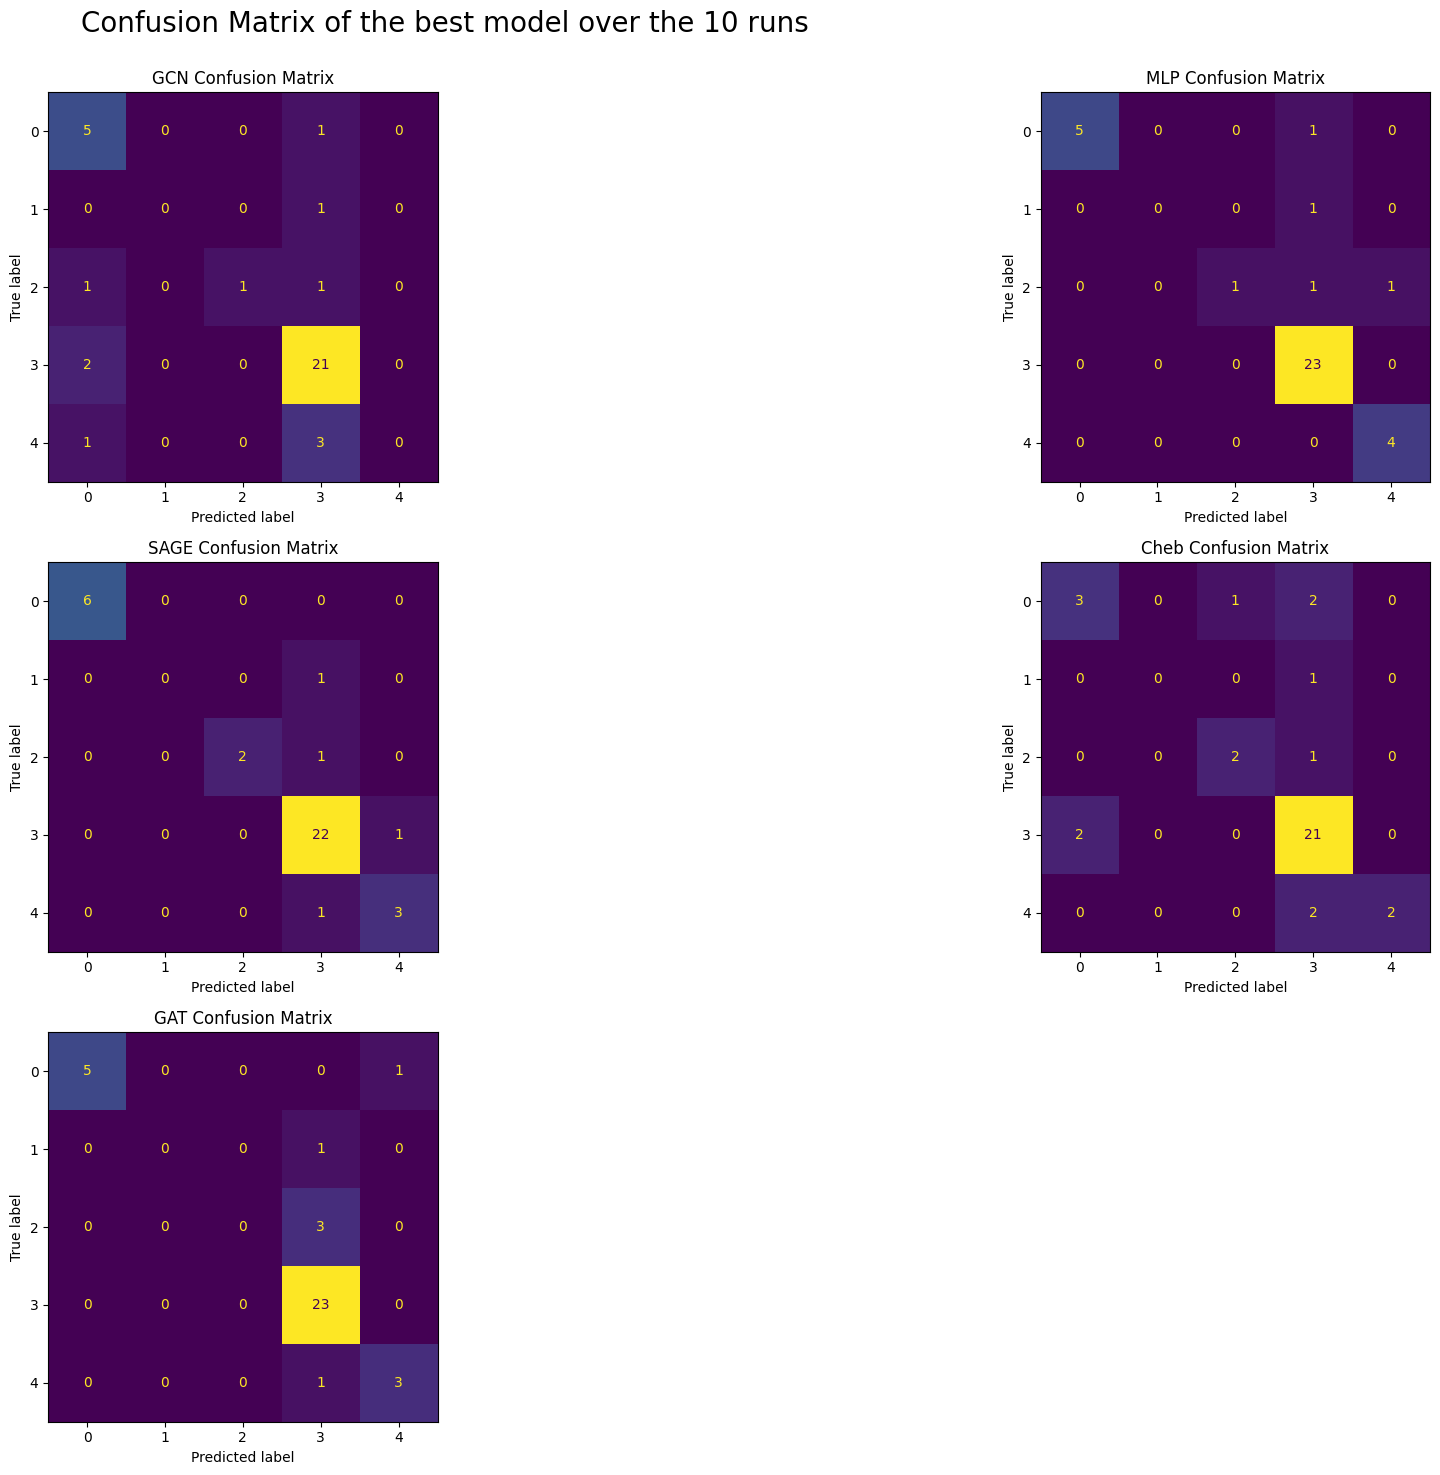

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear las matrices de confusión
conf_matrix_gcn = confusion_matrix(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_mlp = confusion_matrix(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_sage = confusion_matrix(data.y[test_mask].cpu(), global_best_models[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_cheb = confusion_matrix(data.y[test_mask].cpu(), global_best_models[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_gat = confusion_matrix(data.y[test_mask].cpu(), global_best_models[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

# Crear los displays de las matrices de confusión
disp_gcn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gcn, display_labels=data.y.unique().cpu().numpy())
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=data.y.unique().cpu().numpy())
disp_sage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_sage, display_labels=data.y.unique().cpu().numpy())
disp_cheb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cheb, display_labels=data.y.unique().cpu().numpy())
disp_gat = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gat, display_labels=data.y.unique().cpu().numpy())

# Crear la figura y los ejes
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plotear las matrices de confusión
disp_gcn.plot(ax=axs[0][0])
disp_gcn.ax_.set_title('GCN Confusion Matrix')
disp_gcn.im_.colorbar.remove()

disp_mlp.plot(ax=axs[0][1])
disp_mlp.ax_.set_title('MLP Confusion Matrix')
disp_mlp.im_.colorbar.remove()

disp_sage.plot(ax=axs[1][0])
disp_sage.ax_.set_title('SAGE Confusion Matrix')
disp_sage.im_.colorbar.remove()

disp_cheb.plot(ax=axs[1][1])
disp_cheb.ax_.set_title('Cheb Confusion Matrix')
disp_cheb.im_.colorbar.remove()

# Colocar la última matriz en la posición central de la tercera fila
disp_gat.plot(ax=axs[2][0])
disp_gat.ax_.set_title('GAT Confusion Matrix')
disp_gat.im_.colorbar.remove()

# Eliminar el subplot vacío
fig.delaxes(axs[2][1])

# Ajustar el diseño
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)

# Mostrar la figura
plt.show()

#### Report the results in a markdown cell
Put your results in this table:

|  | Cora | Citeseer | Actor | Chamaleon | Squirrel | Wisconsin | Squirrel | Cornell | Texas |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| MLP | 75.074 $\pm{1.562}$ | 71.411 $\pm{1.703}$ | 36.000 $\pm{0.961}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 89.804 $\pm{5.934}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| GCN | 80.590 $\pm{1.062}$ | 72.492 $\pm{1.394}$ | 30.658 $\pm{1.326}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 69.216 $\pm{5.338}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |


### TASK 3
Make a summary of the architecture of the model you used. What are the parameters of the model? What is the number of parameters of the model? What is the number of trainable parameters of the model? Why they perform differently? What happens if you add to much layers of GNNs? During your summary, you can cite the different papers you used to implement your model.
### TASK 4
During the experiments, you have used different datasets with different **Heterophily** and **Homophily**:

1.   Explain what is the Heterophily and Homophily. Implement a function so that given a graph/dataset you obtain the edge-homophility.  
2.   What is the impact of the Heterophily and Homophily on the performance of the model?
3.   Include the edge-homophily of each dataset in the table above. Explain your conclusions on behalf of the edge-homophily.
